## Basic Tutorial: Rabi Experiment

To see how Qililab can help you running calibration experiments on your Quantum Computer, we are going to explore the
Rabi experiment, one of the first experiments in every Quantum Computer calibration cycle.

### Rabi Experiment

A Rabi experiment aims to find the $\pi$ pulse amplitude that will help you excite your qubit from 
ground state, $| 0 \rangle$, to the excited state, $| 1 \rangle$. In order to find the right amplitude, we want to get
what is known as the Rabi amplitude, which corresponds to the amplitude of the half cycle of driving your qubit to the 
excited state, back to the ground state, and again to the excited state, that is, a $360\degree$ rotation around $\sigma_x$ on the Bloch 
sphere.
<div>
<img src="images/bloch.gif" width="300"/>
</div>


By finding the half cycle amplitude value, we are able to know which amplitude our $\pi$ pulse must have in order to perform an excitation
from $| 0 \rangle$ to $| 1 \rangle$. This translates into the next basic circuit:

<div>
<img src="images/rabi_circuit.png" width="300"/>
</div>

In this circuit, we are performing first a rotation of $\pi$ radians around the $X$ axis of the Bloch sphere, starting from the
ground state, which should drive our qubit to the excited state. Then we measure the expected value, on the $Z$ axis base, this is
$\langle \sigma_z \rangle$ and register the measured value. 

Breaking this step by step, starting in the ground state $| 0 \rangle = \left[\begin{array}{ll}
1 & 0
\end{array}\right]^T$ we first perform the $\pi$ radians rotation about the $X$ axis of the Bloch sphere:

$R_x\left(\pi\right)=e^{-i \pi \sigma_x / 2}=\left[\begin{array}{cc}
\cos \cfrac{\pi}{2} & -i \sin \cfrac{\pi}{2} \\
-i \sin \cfrac{\pi}{2} & \cos \cfrac{\pi}{2}
\end{array}\right] = \left[\begin{array}{cc}
0 & -i  \\
-i & 0
\end{array}\right]$

after which the qubit is in the state $| \psi \rangle = R_x | 0 \rangle$. All we have to do now is to measure the expectation value 
of the qubit on the $Z$ axis of the Bloch sphere $\langle \psi | \sigma_z | \psi \rangle$, by using the Pauli-Z operator

$\sigma_z=\left[\begin{array}{cc}
1 & 0 \\
0 & -1
\end{array}\right]$

which gives us an expectation value of $-1$, meaning our qubit is now in the excited $| 1 \rangle = \left[\begin{array}{ll}
0 & 1
\end{array}\right]^T$. Let's check how to implement this circuit and the full experiment using Qililab.



### Importing Qililab, Qibo, Numpy, Matplotlib and TQDM

Qililab supports quantum circuits by using the Qibo library. For the Rabi experiment we will need to import the circuits functionality
from Qibo, as well as its quantum gates module, to be able to use the measurement gate. We will use numpy to treat the experiment 
resulting data as well as Matplotlib to display the results. Finally, we will also import the tqdm library to display the progress
bar as the experiment progresses.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qibo import gates
from qibo.models import Circuit
from tqdm.auto import tqdm

import qililab as ql

ql.logger.setLevel(40)  # set qililab's logger to a higher level so it only shows error messages

2023-12-21 18:08:19,914 - qm - INFO     - Starting session: 533a1975-a895-4295-a1cf-f17dd38e1e1d


### Experiment constants

Next we are going to define some constants our experiment will be using. In order to calibrate the amplitude for our $\pi$ pulse, 
we need to loop over a subset of amplitudes around which one we expect to find the right amplitude to drive our qubit from the 
ground state, $| 0 \rangle$, to the excited state, $| 1 \rangle$.

First, we need to indicate Qililab which qubit, from our chip, we want to interact with. We will need to define the amplitude 
values array, for which we will use the numpy function linspace, wrapping the initial and final amplitude values, and the number of 
steps to generate in between. 

The hardware average constant allows us to specify the average of values for the results of the experiment. The repetition duration is the total time of execution of each shot. This duration accounts for the extra time required for the qubit to relax back to its ground state. For example, if a circuit takes 4,000ns to execute, there will be a wait time of `REPETITION_DURATION` - 4,000 before the next shot execution.

Finally, we need to specify where our runcard is located so Qililab can instatiate our laboratory setup correctly. The runcard contains all necessary information about our laboratory setup (instruments, connection mappings, ips, etc) as well as the calibrated parameters for the quantum chip being used (pulse amplitudes, distorsions, pulse offsets, etc).

In [2]:
QUBIT = 0
M_BUFFER_TIME = 0
AMP_VALUES = np.linspace(0, 0.4, num=61)
HW_AVG = 1000
REPETITION_DURATION = 200_000
RUNCARD_PATH = "runcards/galadriel.yml"

### Circuit Definition

Now we need to define the circuit we want to run. Qililab uses qibo as its higher level framework to build circuits and complex algorithms. The circuit for the rabi experiment is quite simple. As seen in the figure above, we just need a pi-pulse (drag pulse with amplitude of pi) and a measurement. We also add some buffer time between the drag pulse and the measurement in case we want to experiment with the qubit's excitation induced by the pulse.

[Drag pulses](https://arxiv.org/abs/0901.0534) are the native pulses used as one-qubit gates for our chip.

In [3]:
# Define circuit
circuit = Circuit(QUBIT + 1)
circuit.add(ql.Drag(QUBIT, theta=np.pi, phase=0))
circuit.add(ql.Wait(QUBIT, M_BUFFER_TIME))
circuit.add(gates.M(QUBIT))

MeasurementResult(qubits=(0,), nshots=0)

### Platform Initialization

We run the following steps to initialize the platform:
- `build_platform` loads the configuration file for the platform into memory
- `connect` connects to the instruments specified in platform
- `initial_setup` sets the instruments values for each controlled parameter to those specified in platform
- `turn_on_instruments` turns the instruments on and sets them ready to run

In [4]:
platform = ql.build_platform(runcard=RUNCARD_PATH)
platform.connect()
platform.initial_setup()
platform.turn_on_instruments()

Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/114600, firmware:4.2.76.0-4.30.046.295) in 0.11s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/101901, firmware:4.2.76.0-4.30.046.295) in 0.08s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/114033, firmware:4.2.76.0-4.30.046.295) in 0.07s


### Experiment execution

Now we are ready to launch the experiment. We create an empty list to which we will store each the results from each loop in the experiment. Then we define the loop we want to run and execute it through platform. Note as well how we use platform to set the value we are varying at each iteration.

In the case of the rabi experiment, we are interested on iterating through several values of the pulse amplitude in order to tune which value excites the qubit to its $| 1\rangle$ state, that is, we want to find the amplitude of the pi-pulse.

In [5]:
# Run experiment
results_list = []
for amp in tqdm(iterable=AMP_VALUES, total=len(AMP_VALUES), desc="Amplitude"):
    platform.set_parameter(alias=f"Drag({QUBIT})", parameter=ql.Parameter.AMPLITUDE, value=float(amp))
    result = platform.execute(program=circuit, num_avg=HW_AVG, repetition_duration=REPETITION_DURATION)
    results_list.append(result.array)

results = np.hstack(results_list)

Amplitude:   0%|          | 0/61 [00:00<?, ?it/s]

Once we have gathered all the results, we plot them to see the characteristic rabi plot and identify the point at which the $|0 \rangle \rightarrow |1 \rangle$ excitation happens

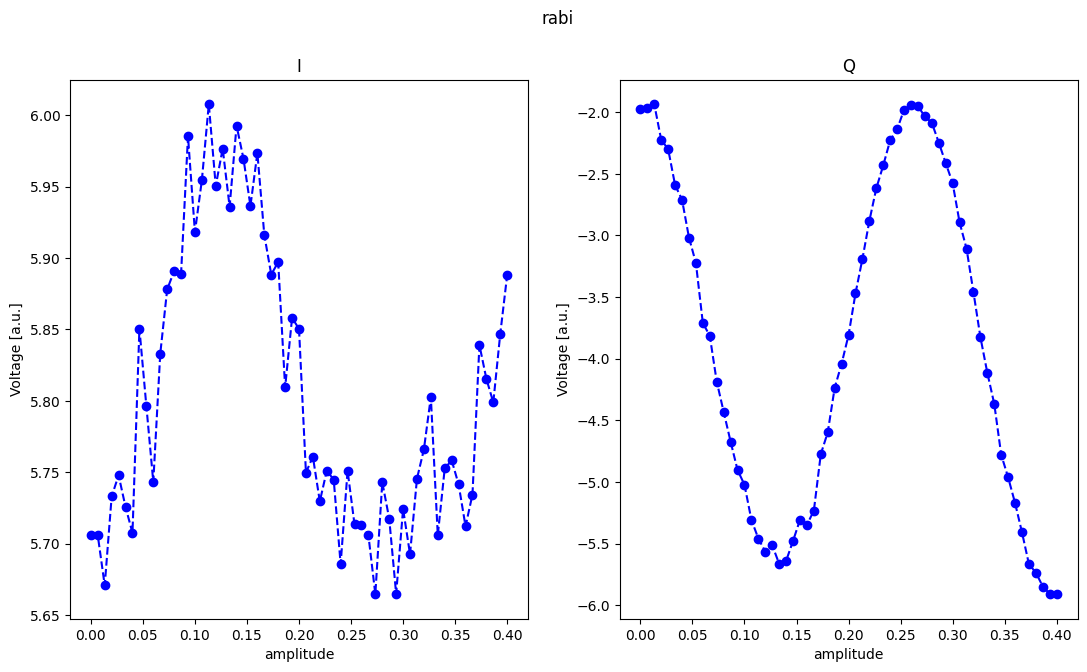

In [6]:
def plot_iq(xdata, results: np.ndarray, title_label: str, xlabel: str):
    fig, axes = plt.subplots(1, 2, figsize=(13, 7))

    if isinstance(axes, np.ndarray):
        axes[0].plot(xdata, results[0], "--o", color="blue")
        axes[1].plot(xdata, results[1], "--o", color="blue")
        axes[0].set_title("I")
        axes[1].set_title("Q")
        axes[0].set_xlabel(xlabel)
        axes[1].set_xlabel(xlabel)
        axes[0].set_ylabel("Voltage [a.u.]")
        axes[1].set_ylabel("Voltage [a.u.]")
        
    fig.suptitle(title_label)
    return fig, axes

plot_iq(xdata=AMP_VALUES, results=results, title_label="rabi", xlabel="amplitude")
plt.show()

In this case we want to pick the value for the first minima for Q, around 0.13.